# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [39]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')
customers

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Channel           440 non-null    category
 1   Region            440 non-null    category
 2   Fresh             440 non-null    int64   
 3   Milk              440 non-null    int64   
 4   Grocery           440 non-null    int64   
 5   Frozen            440 non-null    int64   
 6   Detergents_Paper  440 non-null    int64   
 7   Delicassen        440 non-null    int64   
 8   Retail Sales SUM  440 non-null    int64   
dtypes: category(2), int64(7)
memory usage: 25.1 KB


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Retail Sales SUM
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690,0.575178
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368,0.776909
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497,0.740680
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947,0.388436
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291,0.633882
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000,0.496849
Retail Sales SUM,0.575178,0.776909,0.740680,0.388436,0.633882,0.496849,1.000000


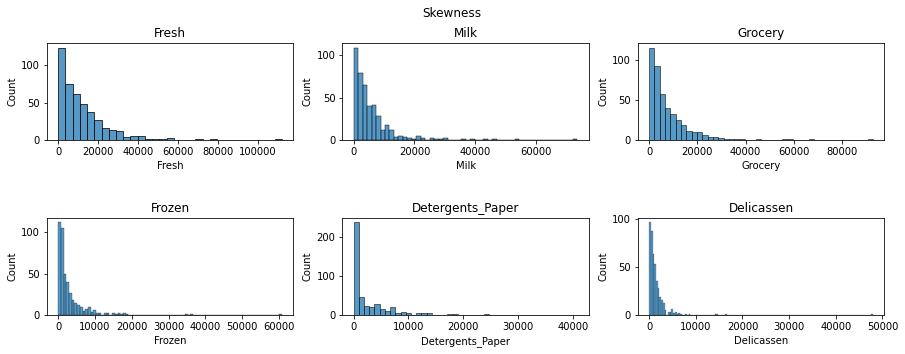

In [47]:
# Your code here:
customers.info()
#The Channel and Region are categorical values!
#The last 6 columns are the amount in a scpecific fiat currency that a 
#costumer (rows) spend in each supermarket sub-category of items
customers.isna().sum()
#No NaNs, no need to remove or fill missing data

#column collinearity?
display(customers.corr())
#Detergents_Paper and Grocery have a 0.92 positive correlation

customers.describe()
#No outliers to be removed

#Plotting frequencies
fig, axes = plt.subplots(2, 3, figsize=(15 , 5))
plt.subplots_adjust(hspace = 0.8)
fig.suptitle('Skewness')
sns.histplot(ax=axes[0,0], data=customers['Fresh'])
axes[0,0].set_title('Fresh')

sns.histplot(ax=axes[0,1], data=customers['Milk'])
axes[0,1].set_title('Milk')

sns.histplot(ax=axes[0,2], data=customers['Grocery'])
axes[0,2].set_title('Grocery')

sns.histplot(ax=axes[1,0], data=customers['Frozen'])
axes[1,0].set_title('Frozen')

sns.histplot(ax=axes[1,1], data=customers['Detergents_Paper'])
axes[1,1].set_title('Detergents_Paper')

sns.histplot(ax=axes[1,2], data=customers['Delicassen'])
axes[1,2].set_title('Delicassen')

#Positive Skewness on all sub categories

#Pareto check
customers['Retail Sales SUM'] = customers['Fresh'] + customers['Milk'] + customers['Grocery'] + customers['Frozen'] + customers['Detergents_Paper'] + customers['Delicassen']

In [33]:
# Your observations here
customers1 = customers.sort_values('Retail Sales SUM').reset_index(drop=True)
n=len(customers1)
high20sales=sum(customers1['Retail Sales SUM'][int(0.80*n):])
low80sales=sum(customers1['Retail Sales SUM'][:int(0.80*n)])

In [34]:
display(high20sales)
display(low80sales)
#more likely to be a 25/75
high25sales=sum(customers1['Retail Sales SUM'][int(0.75*n):])
low75sales=sum(customers1['Retail Sales SUM'][:int(0.75*n)])

display(high25sales)
low75sales
#confirmed



6272473

8347027

7251776

7367724

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [6]:
# Your code here
customers['Channel'] = customers['Channel'].astype('category',copy=False)
customers['Region'] = customers['Region'].astype('category',copy=False)

In [7]:
# Your comment here
customers_dummies = pd.get_dummies(customers)

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [8]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:


# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [9]:
# Your code here:


Count the values in `labels`.

In [10]:
# Your code here:


# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [11]:
# Your code here


Count the values in `labels_DBSCAN`.

In [12]:
# Your code here


# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

In [13]:
# Your code here:


Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

In [14]:
# Your code here:


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

In [15]:
# Your code here:

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [16]:
# Your code here:


Which algorithm appears to perform better?

In [17]:
# Your observations here

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [18]:
# Your code here

In [19]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [20]:
# Your code here

In [21]:
# Your comment here